In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import spacy
spacy_en = spacy.load('en')

import dill as pickle

In [3]:
PATH = 'data/toxic-comment'
bsz = 32

## Examine the data

In [4]:
raw_train_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')
sample_subm_df = pd.read_csv(f'{PATH}/sample_submission.csv')

In [5]:
print(f'Train size: {len(raw_train_df)} | Test size: {len(test_df)}')
raw_train_df.head()

Train size: 95851 | Test size: 226998


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [6]:
DataFrameSummary(raw_train_df).summary()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,95851,NaN,95851,95851,95851,95851,95851,95851
mean,4.99436e+11,NaN,0.0963683,0.0100677,0.0533015,0.00318202,0.0497126,0.00849235
std,2.89014e+11,NaN,0.295097,0.0998321,0.224635,0.0563199,0.217352,0.0917623
min,2.22566e+07,NaN,0,0,0,0,0,0
25%,2.47344e+11,NaN,0,0,0,0,0,0
50%,5.0013e+11,NaN,0,0,0,0,0,0
75%,7.50109e+11,NaN,0,0,0,0,0,0
max,9.99988e+11,NaN,1,1,1,1,1,1
counts,95851,95851,95851,95851,95851,95851,95851,95851
uniques,95851,95851,2,2,2,2,2,2


In [7]:
comment_len = raw_train_df.comment_text.str.len()
comment_len.mean(), comment_len.std(), comment_len.max()

(395.34186393464859, 595.10207169971216, 5000)

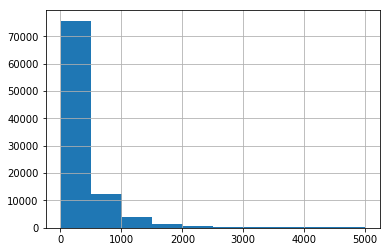

In [8]:
comment_len.hist()

In [9]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
raw_train_df['none'] = 1 - raw_train_df[label_cols].max(axis=1)

DataFrameSummary(raw_train_df).summary()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,95851,NaN,95851,95851,95851,95851,95851,95851,95851
mean,4.99436e+11,NaN,0.0963683,0.0100677,0.0533015,0.00318202,0.0497126,0.00849235,0.897862
std,2.89014e+11,NaN,0.295097,0.0998321,0.224635,0.0563199,0.217352,0.0917623,0.302831
min,2.22566e+07,NaN,0,0,0,0,0,0,0
25%,2.47344e+11,NaN,0,0,0,0,0,0,1
50%,5.0013e+11,NaN,0,0,0,0,0,0,1
75%,7.50109e+11,NaN,0,0,0,0,0,0,1
max,9.99988e+11,NaN,1,1,1,1,1,1,1
counts,95851,95851,95851,95851,95851,95851,95851,95851,95851
uniques,95851,95851,2,2,2,2,2,2,2


## Build dataset and ModelData classes

In [10]:
class ToxicDataset(torchtext.data.Dataset):
    def __init__(self, df, tt_text_field, tt_label_field, txt_col, lbl_col, **kwargs):
        fields = [('text', tt_text_field), ('label', tt_label_field)]
        
        examples = []
        for idx, row in df.iterrows():
            lbl = row[lbl_col] if lbl_col in row else None
            txt = row[txt_col]
            examples.append(data.Example.fromlist([txt,lbl], fields))
                            
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(example): return len(example.text)
    
    @classmethod
    def splits(cls, text_field, label_field, train_df, txt_col, lbl_col, val_df=None, test_df=None, **kwargs):
        
        # build train, val, and test data
        train_data = None if train_df is None else cls(train_df, text_field, label_field, txt_col, lbl_col, **kwargs)
        val_data = None if val_df is None else cls(val_df, text_field, label_field, txt_col, lbl_col, **kwargs)
        test_data = None if test_df is None else cls(test_df, text_field, label_field, txt_col, lbl_col, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [11]:
class TextDataRegression(ModelData):  
    
    def create_td(self, it):
        return TextDataLoader(it, self.text_fld, self.label_fld)

    @classmethod
    def from_splits(cls, path, splits, bs, text_name='text', label_name='label'):
        text_fld = splits[0].fields[text_name]
        label_fld = splits[0].fields[label_name]
        
        if (not hasattr(text_fld, 'vocab')): text_fld.build_vocab(splits[0], max_size=20000)
     
        iters = torchtext.data.BucketIterator.splits(splits, batch_size=bs)
        trn_iter,val_iter,test_iter = iters[0],iters[1],None
        
        test_dl = None
        if len(iters) == 3:
            test_iter = iters[2]
            test_dl = TextDataLoader(test_iter, text_name, label_name)
        trn_dl = TextDataLoader(trn_iter, text_name, label_name)
        val_dl = TextDataLoader(val_iter, text_name, label_name)
        
        obj = cls.from_dls(path, trn_dl, val_dl, test_dl)
        obj.bs = bs
        obj.pad_idx = text_fld.vocab.stoi[text_fld.pad_token]
        obj.nt = len(text_fld.vocab)
        obj.c = 1 
        return obj


## Prepare data for training

In [12]:
val_idxs = get_cv_idxs(len(raw_train_df), val_pct=0.20)

train_df =  raw_train_df.drop(val_idxs)
val_df = raw_train_df.iloc[val_idxs]

len(train_df), len(val_df), len(test_df)

(76681, 19170, 226998)

In [13]:
def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [86]:
tt_TEXT = data.Field(sequential=True, tokenize=tokenizer, fix_length=10)
tt_LABEL = data.Field(sequential=False, use_vocab=False) # use_vocab=False because labels are numerical

In [87]:
splits = ToxicDataset.splits(tt_TEXT, tt_LABEL, train_df, 'comment_text', 'toxic', val_df, None)

In [88]:
t = splits[0].examples[0]
t.label, ' '.join(t.text[:10])

(1, 'Nonsense ?   kiss off , geek . what I')

In [89]:
md = TextDataRegression.from_splits(PATH, splits, bsz, text_name='text', label_name='label')

In [90]:
len(md.trn_dl), md.nt

(2396, 20002)

In [91]:
print(tt_TEXT.vocab.stoi[tt_TEXT.pad_token])
print(tt_TEXT.vocab.itos[:10])

1
['<unk>', '<pad>', '.', ',', 'the', '"', 'to', 'I', 'of', 'and']


In [92]:
tt_TEXT.vocab.freqs.most_common(10)

[('.', 248052),
 (',', 226297),
 ('the', 214636),
 ('"', 181109),
 ('to', 140073),
 ('I', 107615),
 ('of', 106223),
 ('and', 101517),
 ('a', 98639),
 ('you', 87303)]

In [93]:
tt_TEXT.vocab.freqs.most_common()[-10:]

[('aggio', 1),
 ('fulltext', 1),
 ('SvWp', 1),
 ('alums', 1),
 ('pantsed', 1),
 ('Heonsi', 1),
 ('R41', 1),
 ('trotting', 1),
 ('plskthxbai', 1),
 ('wahabi', 1)]

In [94]:
print(tt_TEXT.vocab.stoi['aggio']) 

# max_size is based on most frequent words, any words that don't make it = <unk>

0


In [95]:
txt = train_df.iloc[0].comment_text
print(txt)

txt_pp = tt_TEXT.preprocess(txt)
print(txt_pp)


Nonsense?  kiss off, geek. what I said is true.  I'll have your account terminated.
['Nonsense', '?', ' ', 'kiss', 'off', ',', 'geek', '.', 'what', 'I', 'said', 'is', 'true', '.', ' ', 'I', "'ll", 'have', 'your', 'account', 'terminated', '.']


## Train

In [ ]:
n_hidden = 256
n_fac = 42

In [ ]:
class LstmClassifier(nn.Module):
    def __init__(self, vocab_size, n_fac, bs, nl=1, out_sz=1):
        super().__init__()
        
        self.vocab_size, self.nl = vocab_size, nl
        
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, out_sz)
        
        self.h = init_hidden(bs)
        
    def forward(self, comment):
        
        outp, h = self.rnn(self.e(comment), self.h)
        self.h = repackage_var(h)
        
        x = self.l_out(outp[-1], dim=-1).view(-1, self.vocab_size)
        x = F.dropout(x, 0.1)
        
        return F.sigmoid(x)
    
    def init_hidden(self, bs):
        return(V(torch.zeros(self.nl, bs, n_hidden)), V(torch.zeros(self.nl, bs, n_hidden)))

In [ ]:
m = LstmClassifier(md.nt, n_fac, bsz, 2, 1)#.cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
fit(m, md, 6, opt, [accuracy])

In [ ]:
set_lrs(opt, 1e-4)

In [ ]:
fit(m, md, 3, opt, F.nll_loss)

In [ ]:
b = next(iter(iters[0]))